# 1. Preamble

In [57]:
import pandas
import math
import networkx as nx
import networkx.algorithms
import sklearn
import sklearn.cluster
import sklearn.preprocessing
import matplotlib.pyplot as plt

# 2. Data Import and Exploration

## 2.1 First Dataset ( Company and Directors )

In [58]:
company_director_raw = pandas.read_csv('/content/company_directorships.csv')
company_director_raw.head(5)

,company_name,cikcode,director_name,software_background,start_date,end_date
0,1ST SOURCE CORP,34782,ALLISON N. EGIDI,f,2011-03-14,2017-03-14
1,1ST SOURCE CORP,34782,ANDREA G. SHORT,f,2023-03-10,2025-03-14
2,1ST SOURCE CORP,34782,CHRISTOPHER J. MURPHY III,t,2008-03-14,2025-03-14
3,1ST SOURCE CORP,34782,CHRISTOPHER J. MURPHY IV,f,2011-03-14,2025-03-14
4,1ST SOURCE CORP,34782,CRAIG A. KAPSON,f,2008-03-14,2017-03-14


In [59]:
company_director_raw.info()
missing_values = company_director_raw.isnull().sum()
print("Missing values in each column:\n", missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13347 entries, 0 to 13346
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   company_name         13347 non-null  object
 1   cikcode              13347 non-null  int64 
 2   director_name        13347 non-null  object
 3   software_background  13347 non-null  object
 4   start_date           13347 non-null  object
 5   end_date             13347 non-null  object
dtypes: int64(1), object(5)
memory usage: 625.8+ KB
Missing values in each column:
 company_name           0
cikcode                0
director_name          0
software_background    0
start_date             0
end_date               0
dtype: int64


In [60]:
company_director_raw['company_name'] = company_director_raw.company_name.str.upper().str.strip()
company_director_raw.groupby('company_name').director_name.nunique().sort_values(ascending=False)

,director_name
company_name,
INVESCO ADVANTAGE MUNICIPAL INCOME TRUST II,55
INVESCO MUNICIPAL OPPORTUNITY TRUST,55
INVESCO TRUST FOR INVESTMENT GRADE NEW YORK MUNICIPALS,55
INVESCO PENNSYLVANIA VALUE MUNICIPAL INCOME TRUST,55
INVESCO MUNICIPAL TRUST,55
...,...
"LEE PHARMACEUTICALS, INC.",3
KONINKLIJKE PHILIPS NV,3
CONNECTICUT LIGHT & POWER CO,2


In [61]:
company_director_raw['director_name'] = company_director_raw.director_name.str.upper().str.strip()
company_director_raw.groupby('director_name').company_name.nunique().sort_values(ascending=False)

,company_name
director_name,
ALBERT R. DOWDEN,14
DOUGLAS SHARP,13
ROBERT C. TROCCOLI,13
DAVID C. ARCH,13
PREMA MATHAI-DAVIS,13
...,...
HOWARD A. BRECHER,1
HOWARD A. SEVERSON,1
"HOWARD B. SILVERMAN, PH.D.",1


In [62]:
company_director_raw.groupby('software_background').count()

,company_name,cikcode,director_name,start_date,end_date
software_background,,,,,
f,11021,11021,11021,11021,11021
t,2326,2326,2326,2326,2326


## 2.2 Second Dataset ( Director Details )

In [63]:
director_details_raw = pandas.read_csv('/content/director-details.csv')
director_details_raw.sample(5)

,id,url,name,age,role,compensation,source_excerpt,created_at,gender
3917,3909,https://www.sec.gov/Archives/edgar/data/102752...,Edward P. Dolanski,57,"Former President, U.S. Government Services at ...",190039,"Edward P. Dolanski: Age: 57, Director Since: 2...",2025-05-16 16:34:37.611706,male
3946,3937,https://www.sec.gov/Archives/edgar/data/103595...,Perry J. Blatt,48,Director of E-Commerce and Business Developmen...,50000,Perry J. Blatt is the Director of E-Commerce a...,2025-05-16 16:34:40.010153,male
5410,5408,https://www.sec.gov/Archives/edgar/data/715957...,James A. Bennett,63,Independent Director,314994,James A. Bennett Age: 63 Director Since: 2019 ...,2025-05-16 16:36:57.618833,male
2928,2918,https://www.sec.gov/Archives/edgar/data/76267/...,Dale Blanchfield,86,"Director, Lead Independent Director",46675,Dale E. Blanchfield has been a director of the...,2025-05-16 16:33:12.908209,male
3381,3363,https://www.sec.gov/Archives/edgar/data/91388/...,"Wendell H. Murphy, Sr.",73,"Private Investor; Former CEO Murphy Farms, Inc.",162000,"Although now a private investor, Mr. Murphy pr...",2025-05-16 16:33:51.30849,male


In [64]:
director_details_raw.info()
missing_values = director_details_raw.isnull().sum()
print("Missing values in each column:\n", missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              5910 non-null   int64 
 1   url             5910 non-null   object
 2   name            5910 non-null   object
 3   age             5910 non-null   int64 
 4   role            5909 non-null   object
 5   compensation    5910 non-null   int64 
 6   source_excerpt  5910 non-null   object
 7   created_at      5910 non-null   object
 8   gender          5889 non-null   object
dtypes: int64(3), object(6)
memory usage: 415.7+ KB
Missing values in each column:
 id                 0
url                0
name               0
age                0
role               1
compensation       0
source_excerpt     0
created_at         0
gender            21
dtype: int64


In [65]:
director_details_raw['name'] = director_details_raw.name.str.upper().str.strip()
director_details_raw.name.nunique()

5421

In [66]:
director_details_raw['gender'].value_counts(dropna=False)


,count
gender,
male,4176
female,1711
NaN,21
unknown,2


## 2.3 Third Dataset (Task 4)

In [67]:
top_companies_raw = pandas.read_csv('/content/fortune1000_2024.csv')
top_companies_raw.sample(5)

,Rank,Company,Ticker,Sector,Industry,Profitable,Founder_is_CEO,FemaleCEO,Growth_in_Jobs,Change_in_Rank,...,Assets_M,CEO,Country,HeadquartersCity,HeadquartersState,Website,CompanyType,Footnote,MarketCap_Updated_M,Updated
574,575,Coterra Energy,CTRA,Energy,"Mining, Crude-Oil Production",yes,no,no,no,-155.0,...,20415.0,Thomas E. Jorden,U.S.,Houston,Texas,https://www.coterra.com,Public,"Market value as of March 28, 2024.",20946.0,2024-06-04
866,867,BOK Financial,BOKF,Financials,Commercial Banks,yes,no,no,yes,0.0,...,49824.8,Stacy C. Kymes,U.S.,Tulsa,Oklahoma,https://www.bokf.com,Public,"Market value as of March 28, 2024.",5946.0,2024-06-04
77,78,New York Life Insurance,NaN,Financials,"Insurance: Life, Health (Mutual)",yes,no,no,yes,-7.0,...,408904.9,Craig DeSanto,U.S.,New York,New York,https://www.newyorklife.com,Private,"Figures are for fiscal year ended Dec. 31, 2022.",NaN,2024-08-05
23,24,Marathon Petroleum,MPC,Energy,Petroleum Refining,yes,no,no,yes,-8.0,...,85987.0,Maryann T. Mannen,U.S.,Findlay,Ohio,https://www.marathonpetroleum.com,Public,Excise taxes have been deducted. Market value ...,58737.0,2024-08-05
150,151,Amgen,AMGN,Health Care,Pharmaceuticals,yes,no,no,yes,3.0,...,97154.0,Robert A. Bradway,U.S.,Thousand Oaks,California,https://www.amgen.com,Public,"Market value as of March 28, 2024.",152373.0,2024-06-04


In [68]:
top_companies_raw.info()
missing_values = top_companies_raw.isnull().sum()
print("Missing values in each column:\n", missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Rank                           1000 non-null   int64  
 1   Company                        1000 non-null   object 
 2   Ticker                         959 non-null    object 
 3   Sector                         1000 non-null   object 
 4   Industry                       1000 non-null   object 
 5   Profitable                     1000 non-null   object 
 6   Founder_is_CEO                 1000 non-null   object 
 7   FemaleCEO                      1000 non-null   object 
 8   Growth_in_Jobs                 1000 non-null   object 
 9   Change_in_Rank                 1000 non-null   float64
 10  Gained_in_Rank                 1000 non-null   object 
 11  Dropped_in_Rank                1000 non-null   object 
 12  Newcomer_to_the_Fortune500     500 non-null    ob

In [69]:
top_companies_raw['Company'] = top_companies_raw.Company.str.upper().str.strip()
top_companies_raw.Company.nunique()

1000

In [70]:
director_companies = set(company_director_raw['company_name'].unique())
fortune_1000_companies = set(top_companies_raw['Company'].unique())

matched_companies = director_companies & fortune_1000_companies
matched_count = len(matched_companies)

print(f"Number of Fortune 1000 companies in company_director dataset: {matched_count}")

Number of Fortune 1000 companies in company_director dataset: 8


# 3. Data Cleaning and Preprocessing

In [11]:
company_director = company_director_raw.drop( ['cikcode', 'director_name'], axis = 1)
company_director.software_background = company_director.software_background.map(lambda x: x == 't')
company_director['service_years'] = round((pandas.to_datetime(company_director.end_date) - pandas.to_datetime(company_director.start_date)).dt.days / 365, 2)
company_director.sample(5)

,company_name,software_background,start_date,end_date,NAME,service_years
2612,COMERICA INC /NEW/,True,2023-03-13,2025-03-17,DEREK J. KERR,2.01
12954,WESBANCO INC,False,2018-03-13,2023-03-15,GARY L. LIBS,5.01
12728,"VAXART, INC.",False,2013-10-01,2013-10-01,RICHARD HILL,0.00
3451,"DINE BRANDS GLOBAL, INC.",False,2017-04-03,2024-03-29,CAROLINE W. NAHAS,6.99
6721,INVESCO QUALITY MUNICIPAL INCOME TRUST,True,2017-07-26,2024-07-02,TERESA M. RESSEL,6.94


In [12]:
def most_common(series):
    mode_values = series.mode()
    if len(mode_values) > 0:
        return mode_values[0]
    return None

def role_importance(role):
    if pandas.isna(role): return 1
    role = role.lower()
    if 'chief executive officer' in role or 'ceo' in role:
        return 10
    elif 'chair' in role:
        return 7
    elif 'president' in role:
        return 5
    elif 'director' in role:
        return 3
    else:
        return 1

In [13]:
director_details_raw['role_score'] = director_details_raw['role'].map(role_importance)
director_details = pandas.DataFrame({
    'age': director_details_raw.groupby('NAME').age.max(),
    'compensation': director_details_raw.groupby('NAME').compensation.sum(),
    'gender': director_details_raw.groupby('NAME').gender.agg(most_common),
    'role_score': director_details_raw.groupby('NAME').role_score.max(),
})
director_details['log_compensation'] = (1 + director_details.compensation).map(math.log10)
director_details

,age,compensation,gender,role_score,log_compensation
NAME,,,,,
A. CATHERINE NGO,64,1006154,female,3,6.002665
A. EUGENE WASHINGTON,70,324871,male,3,5.511712
A. F. PETROCELLI,80,47000,male,10,4.672107
A. FARAZ ABBASI,52,113631,male,3,5.055501
A. LARRY CHAPMAN,78,259500,male,3,5.414139
...,...,...,...,...,...
ZACKARY IRANI,58,360103,male,10,5.556428
ZAHID AFZAL,62,0,male,3,0.000000
ZENA SRIVATSA ARNOLD,46,189960,female,3,5.278664


In [14]:
influence_factors = pandas.merge(company_director[['company_name', 'NAME', 'service_years']], director_details, on='NAME', how='left').fillna(0)
influence_factors['weight'] = 1 / (
    influence_factors['log_compensation'].clip(lower=1) *
    influence_factors['role_score'].clip(lower=1) *
    influence_factors['service_years'].clip(lower=1)
)

In [15]:
influence_factors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13347 entries, 0 to 13346
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company_name      13347 non-null  object 
 1   NAME              13347 non-null  object 
 2   service_years     13347 non-null  float64
 3   age               13347 non-null  float64
 4   compensation      13347 non-null  float64
 5   gender            13347 non-null  object 
 6   role_score        13347 non-null  float64
 7   log_compensation  13347 non-null  float64
 8   weight            13347 non-null  float64
dtypes: float64(6), object(3)
memory usage: 938.6+ KB


In [16]:
influence_factors.sample(5)

,company_name,NAME,service_years,age,compensation,gender,role_score,log_compensation,weight
10232,RPM INTERNATIONAL INC/DE/,DR. JERRY SUE THORNTON,4.99,0.0,0.0,0,0.0,0.000000,0.200401
12150,"TYSON FOODS, INC.",MARIA CLAUDIA BORRAS,3.99,55.0,300547.0,female,3.0,5.477914,0.015251
10753,SMITHFIELD FOODS INC,"WENDELL H. MURPHY, SR.",0.99,73.0,162000.0,male,10.0,5.209518,0.019196
11414,TEAM INC,EDWARD J. STENGER,1.96,66.0,215500.0,male,3.0,5.333449,0.031887
116,ABEONA THERAPEUTICS INC.,VISHWAS SESHADRI,0.16,0.0,0.0,0,0.0,0.000000,1.000000


## 3.2 Checking Processed Result

In [17]:
director_details.gender.value_counts(dropna=False)

,count
gender,
male,3850
female,1550
None,19
unknown,2


In [18]:
directorship_counts = company_director.groupby('NAME').company_name.nunique().sort_values()
directorship_counts

,company_name
NAME,
MICHAEL LUETKEMEYER,1
MICHAEL L. KUBACKI,1
MICHAEL L. KUTA,1
MICHAEL L. LARUSSO,1
MICHAEL L. MILLER,1
...,...
CHRISTOPHER L. WILSON,13
LARRY SOLL,13
ELI JONES,13


<Axes: xlabel='company_name'>

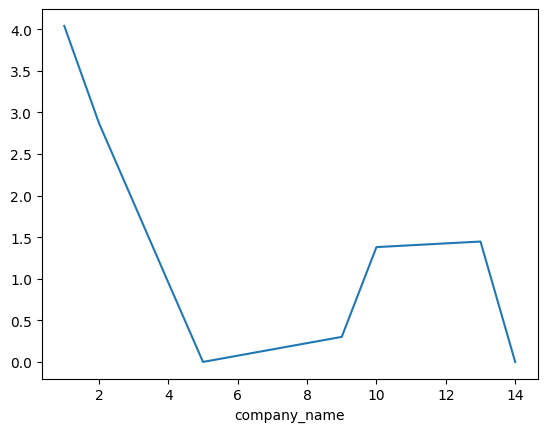

In [19]:
directorship_counts.value_counts().sort_index().map(math.log10).plot()

# 4. Network Analysis

In [20]:
graph = nx.Graph()
people = []
companies = []
for company_name, director_name, weight in zip(influence_factors.company_name, influence_factors.NAME, influence_factors.weight):
    graph.add_edge(company_name, director_name, weight=weight)
    people.append(director_name)
    companies.append(company_name)

In [21]:
biggest_connected_graph = graph.subgraph(list(networkx.connected_components(graph))[0])
print(len(list(networkx.connected_components(graph))))
print(len(biggest_connected_graph.nodes()), len(biggest_connected_graph.edges()))

196
8204 9233


In [22]:
%%time
centrality = pandas.DataFrame({
    'eigen': pandas.Series(nx.eigenvector_centrality(biggest_connected_graph)),
    'degree': pandas.Series(nx.algorithms.degree_centrality(biggest_connected_graph)),
    'closeness_weighted': pandas.Series(nx.closeness_centrality(biggest_connected_graph, distance='weight'))
})
centrality['is_person'] = centrality.index.map(lambda x: x in people)

CPU times: user 10min 28s, sys: 1.99 s, total: 10min 30s
Wall time: 10min 41s


In [23]:
people_df = centrality[centrality.is_person].merge(director_details, left_index=True, right_index=True)

In [24]:
people_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3742 entries, CHRISTOPHER J. MURPHY III to SUSANA MARTINEZ
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   eigen               3742 non-null   float64
 1   degree              3742 non-null   float64
 2   closeness_weighted  3742 non-null   float64
 3   is_person           3742 non-null   bool   
 4   age                 3742 non-null   int64  
 5   compensation        3742 non-null   int64  
 6   gender              3723 non-null   object 
 7   role_score          3742 non-null   int64  
 8   log_compensation    3742 non-null   float64
dtypes: bool(1), float64(4), int64(3), object(1)
memory usage: 266.8+ KB


In [25]:
people_df.sort_values('closeness_weighted', ascending=False)

,eigen,degree,closeness_weighted,is_person,age,compensation,gender,role_score,log_compensation
DMITRI L. STOCKTON,6.791593e-15,0.000488,1.769441,True,60,1000068,male,10,6.000030
MICHAEL F. HILTON,4.681770e-17,0.000488,1.768572,True,70,971038,male,10,5.987237
ROBERT E. SANCHEZ,1.746878e-15,0.000244,1.768002,True,59,9283808,male,10,6.967726
CLAYTON M. JONES,9.818872e-13,0.000366,1.760647,True,72,311768,male,10,5.493833
"DOUGLAS M. BAKER, JR.",3.422107e-15,0.000366,1.760277,True,65,335128,male,10,5.525212
...,...,...,...,...,...,...,...,...,...
GLORIA E. GEBBIA,8.400282e-35,0.000122,0.148599,True,82,210000,female,3,5.322221
JERRY M. SCHNEIDER,8.400282e-35,0.000122,0.148594,True,79,145000,male,3,5.161371
FRANCIS V. CUTTITA,8.400282e-35,0.000122,0.148594,True,56,145000,male,3,5.161371
CHARLES A. ZABATTA,8.400282e-35,0.000122,0.148575,True,82,245000,male,3,5.389168


In [26]:
# df[df.director_name == 'ELIZABETH KRENTZMAN']

In [27]:
# robust_scaler = sklearn.preprocessing.RobustScaler()
# age_and_demographics_scaled = robust_scaler.fit_transform(people_df[['age', 'log_compensation', 'degree', 'eigen']])

In [28]:
# dbscan = sklearn.cluster.DBSCAN(eps=0.4)
# people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
# people_df.cluster_id.value_counts()

In [29]:
# people_df.plot.scatter(x='age', y='log_compensation', c='cluster_id', cmap="rainbow", s=4)

In [30]:
# people_df.loc['ELIZABETH KRENTZMAN']